In [21]:
import numpy as np
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import matplotlib_inline
from IPython import display
%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# 7.47 ANN for classification
- will use an ANN model for classification of data in two categories
- Scenario: have two data sets, which represent two different types of 'qwerties'. The goal is for the model to successfully categorize a data point to either belong to one set or the other.
- a major challenge will be the accuracy with points that are closer to the decision boundary (0.5)
<br>

**General steps**
1. Create the dataset. This will be done with creating a "data cloud". A center point for each data set will be coded, and random points will be generated from the centers.
2. Building and training the model. Differences from the regression model include the layers, and the loss function.
    - This model will have an *additional activation layer for the final output*. (for illustrative purposes)
        - Generally not best practice, usually this is built into the loss function and raw final output it passed in.
    - The loss function used is `nn.BCELoss()`. BCE stands for 'binary cross entropy'. This is used with categorization problems, instead of using MSE, which was used for prediction problems.
3. Calculating losses and accuracy.
4. Plotting losses vs epochs, and accuracy.

## Creating the dataset
**creating a data cloud**
- The $(x,y)$ coordinates are specified for the *center* of the data cloud. This is seen in as:
<br>
`a = A[0]+np.random.randn(n_per_cluster)*blur, A[1]+np.randn(n_per_cluster)*blur` is basically $a$ = (x * (random stuff), y*(random stuff))
- more random points are created from the center coordinates.<br>

- for the tensor `data`, it will have the shape or matrix dimensions [200,2]. 200 is the number of rows, where each data point will be stored. 2 is the number of columns, corresponding to the data point's value in x and y.

In [22]:
# creating dataset
def create_data_cloud(num_per_cluster, blur_value):
    # center of data cloud
    A = [1,1]
    B = [5,1]

    # generating data points
    a = [A[0]+np.random.randn(num_per_cluster)*blur_value, A[1]+np.random.randn(num_per_cluster)*blur_value]
    b = [B[0]+np.random.randn(num_per_cluster)*blur_value, B[1]+np.random.randn(num_per_cluster)*blur_value]

    # category labels (dummy or 'hot' encoding)
    labels_np = np.vstack((np.zeros((num_per_cluster,1)), np.ones((num_per_cluster, 1)))) # all of dataset a is labeled as 0, all of b as 1

    # concatenate data into matrix
    data_np = np.hstack((a,b)).T

    # convert numpy matrix to pytorch tensor
    data = torch.tensor(data_np).float()
    labels = torch.tensor(labels_np).float()

    return data, labels



In [23]:
# generating data
n_per_cluster = 100
blur = 1
generated_data, generated_labels = create_data_cloud(n_per_cluster, blur)

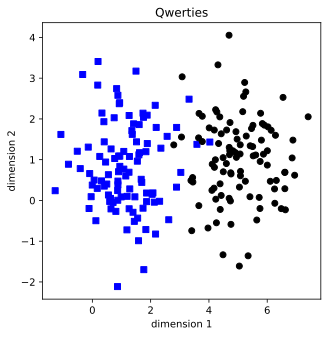

In [24]:
# plotting data
fig = plt.figure(figsize=(5,5))

plt.plot(generated_data[np.where(generated_labels==0)[0],0], generated_data[np.where(generated_labels==0)[0],1], 'bs')
plt.plot(generated_data[np.where(generated_labels==1)[0],0], generated_data[np.where(generated_labels==1)[0],1], 'ko')

plt.title('Qwerties')
plt.xlabel('dimension 1')
plt.ylabel('dimension 2')

plt.show()

In [25]:
# building model
def ANN_classify_build(m_learning_rate):
    ANN_classify = nn.Sequential(
        nn.Linear(2,1), # input. Data is two dimensional. 2 inputs, 1 output.
        nn.ReLU(), # activation
        nn.Linear(1,1), # output
        #nn.Sigmoid() # activation. Generally not recommended to include this layer here. Depends on loss function you are using.
    )

    # model functions
    #loss_func = nn.BCELoss() # NOT recommended- binary cross entropy loss function. Recommended to use BCEWithLogitsLoss() instead.
    loss_func = nn.BCEWithLogitsLoss() # RECOMMENDED- takes raw numerical output from model. More stable sigmoid function built in.
    optimizer = torch.optim.SGD(ANN_classify.parameters(), lr=m_learning_rate)
    
    return ANN_classify, loss_func, optimizer

In [26]:
# training model
def ANN_classify_training(model, loss_function, m_optimizer, input_data, input_labels, epochs = 1000):
    
    # parameters
    losses = torch.zeros(epochs)

    # training
    for epoch_IDX in range(epochs):
        # forward pass
        y_hat = model(input_data)

        # calculating loss
        loss = loss_function(y_hat, input_labels)
        losses[epoch_IDX] = loss

        # backprop
        m_optimizer.zero_grad()
        loss.backward()
        m_optimizer.step()

    # final forward pass
    final_predictions = model(input_data) # final predictions from fully trained model

    # calculating accuracy based on if predicted label == actual label
    # tests if result is greater than 0 AND true. Will create a vector of bools values.
    total_accuracy = 100*torch.mean(((final_predictions>0) == input_labels).float())

    return final_predictions,losses, total_accuracy

In [27]:
# testing- building / training model on data
learning_rate = 0.01

ANN_model, ANN_loss, ANN_optimizer = ANN_classify_build(learning_rate)
results, model_losses, model_accuracy = ANN_classify_training(ANN_model, ANN_loss, ANN_optimizer, generated_data, generated_labels) # results will be between [0,1]

# printing accuracy
print('Final accuracy: %g%%' %model_accuracy)

Final accuracy: 50.5%


In [28]:
# manually calculating losses
predicted_labels = results > 0.5 # True (1) if in category b. False (0) if in category a.

# finding errors
misclassified = np.where(predicted_labels != generated_labels)[0] # checking for dataset a, which should be categorized as 0. 

### Important notes.
- values that are closer to the barrier / decision boundary (0.5) are guesses from the model that are less certain. In an ideal situation, most of the values of the output will be either close to 0 or close to 1.

- the line `predicted_labels = results > 0.5` is taking the output and 'converting' it to boolean labels. This is to interpret the results and calculate the accuracy of how the model categorized data points to either belong to a (false) or b (true). Like normal convention, false represents 0, true represents 1.

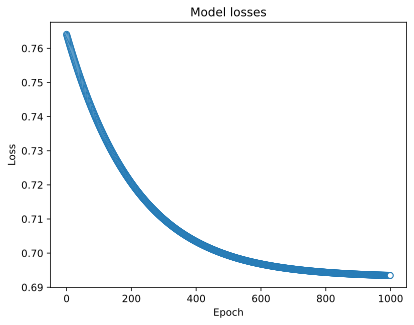

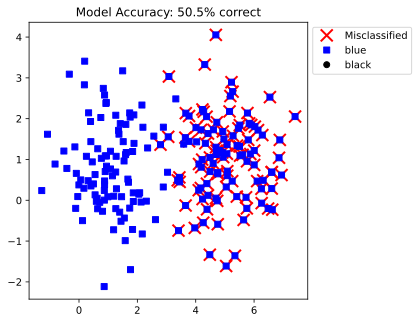

In [29]:
# plotting losses
plt.plot(model_losses.detach(), 'o', markerfacecolor='w', linewidth=0.1)
plt.title('Model losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# plotting accuracy
fig = plt.figure(figsize=(5,5))
plt.plot(generated_data[misclassified,0], generated_data[misclassified,1], 'rx', markersize=12, markeredgewidth=2)
plt.plot(generated_data[np.where(~predicted_labels)[0],0], generated_data[np.where(~predicted_labels)[0],1], 'bs')
plt.plot(generated_data[np.where(predicted_labels)[0],0], generated_data[np.where(predicted_labels)[0], 1], 'ko')

plt.legend(['Misclassified', 'blue', 'black'], bbox_to_anchor=(1,1))
plt.title(f'Model Accuracy: {model_accuracy}% correct')
plt.show()

### Interpreting the results

**In a loss graph:**
- if the losses have *not* hit an **asymptote** at the bottom of the graph, there is **more learning** that the model can do.
- To fix this there are three main things you can do:
    1. Change learning rate.
    2. Change epochs.
    3. Change optimizer.<br>

**In the accuracy graph:**
- the model basically just drew a line. In the graph, the points marked with an x should be the other marker than what is showed. 
- It just tried to have everything above the line be set a, and everything below the line be set b.

***
***
# 7.48 A parametric study of fixed learning rates
- Will experiment with different values for a learning rate.
- Will use small and large learning rates and measure how the model's performance is affected.
**Goal: will train multiple models on same data, but using varied values for a fixed learning rate**
- will also want to have two graphs, one plotting accuracy vs learning rate, the other loss vs epoch.

In [30]:
# note, data set has been generated in an above cell.

# setting up parametric experiment
p_learning_rates = np.linspace(0.001, 0.1, 40) # varied
epochs = 1000 # constant

# storing results
accuracy_each_lr = []
losses_by_run = np.zeros((len(p_learning_rates), epochs))

# parametric study
for i, lr_value in enumerate(p_learning_rates):

    # creating and training model
    ANN_model, ANN_loss, ANN_optimizer = ANN_classify_build(lr_value)
    results, model_losses, model_accuracy = ANN_classify_training(ANN_model, ANN_loss, ANN_optimizer, generated_data, generated_labels) # results will be between [0,1]

    # storing results for each run
    accuracy_each_lr.append(model_accuracy)
    losses_by_run[i,:] = model_losses.detach()

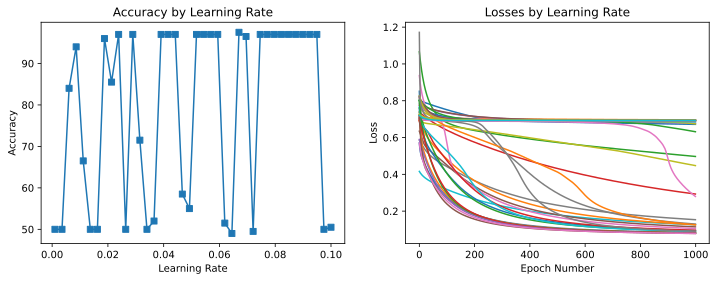

In [31]:
# plotting results
fig, ax = plt.subplots(1, 2, figsize=(12,4))

# plot for accuracy
ax[0].plot(p_learning_rates,accuracy_each_lr, 's-')
ax[0].set_xlabel('Learning Rate')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy by Learning Rate')

# plot for losses
ax[1].plot(losses_by_run.T)
ax[1].set_xlabel('Epoch Number')
ax[1].set_ylabel('Loss')
ax[1].set_title('Losses by Learning Rate')

plt.show()

In [32]:
# further analysis. Taking sum of runs that performed with at least 70% accuracy.
sum(torch.tensor(accuracy_each_lr)>70)/len(accuracy_each_lr)

tensor(0.6250)

### Analyzing the results of this experiment
- The model either was accurate, or did horribly. This is due to the model getting lucky with initial weights.
- Chance played way too large of a role with the model performance.
- The possible solution? Repeat the entire experiment again, and average results.
- This should help eliminate some of the variability, and hopefully make the relationship between learning rate and accuracy more clear.

***
### Meta-experiment to get more reliable results.

In [33]:
# repeating this parametric experiment 50 times.
# variables: initial starting weights, learning rate

# number times to repeat experiment
exp_num = 50

# parameters
epochs_meta = 500

# matrix to store results
accuracy_meta = np.zeros((exp_num, len(p_learning_rates)))

# meta-experiment
for experiment_IDX in range(exp_num):
    for i, lr_value in enumerate(p_learning_rates):

        # creating and training model
        ANN_model, ANN_loss, ANN_optimizer = ANN_classify_build(lr_value)
        results, model_losses, model_accuracy = ANN_classify_training(ANN_model, ANN_loss, ANN_optimizer, generated_data, generated_labels, epochs_meta) # results will be between [0,1]

        # storing accuracy
        accuracy_meta[experiment_IDX, i] = model_accuracy

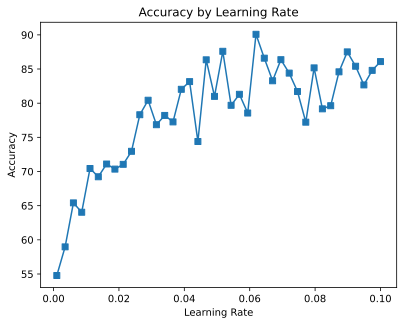

In [34]:
# plotting results, with accuracy being averaged.
plt.plot(p_learning_rates, np.mean(accuracy_meta,axis=0), 's-')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('Accuracy by Learning Rate')
plt.show()